# Generating choice sets


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

For each vendor of interest:
Make a table representing full factorial experiment design.

With columns:

```
v (vendor type code)
v_type (vendor type value)
gc (ground vehicle delivery fee code)
g_cost (ground vehicle delivery fee value)
gt (ground vehicle delivery wait time code)
g_time (ground vehicle delivery wait time value)
dc (drone delivery fee code)
d_cost (drone delivery fee value)
dt (drone delivery wait time code)
d_time (drone delivery wait time value)
dp (drone privacy code)
drone privacy
```

Add in additional columns:

```
d_time - g_time
d_cost - g_cost
exclude (whether to exclude the choice because one option dominates)
sampled (whether choice included in random sample from non-excluded choices)
```

For each vendor, save the 100 sampled choices in a separate file.

`surveyv1-choices-vendor{vendor}-sampled-100.csv`

In [62]:
def get_data_records_for_vendor(v):
    v_type = VENDOR_TYPES[v]
    fees = COST_LEVELS[v]
    wait_times = TIME_LEVELS[v]
    drone_privacy = DRONE_PRIVACY_LEVELS
    print('get data records using')
    print('vendor: %s: %s' % (v, v_type))
    print('delivery fees: %s' % fees)
    print('delivery wait times: %s' % wait_times)
    data_records = []
    for gc, g_cost in enumerate(fees):
        for gt, g_time in enumerate(wait_times):
            for dc, d_cost in enumerate(fees):
                for dt, d_time in enumerate(wait_times):
                    for dp, privacy in enumerate(drone_privacy):
                        data_record = {
                            'v': v,
                            'v_type': v_type,
                            # ground vehicle cost
                            'gc': gc,
                            'g_cost': g_cost[0],
                            # ground vehicle time
                            'gt': gt,
                            'g_time': g_time[0],
                            # drone cost
                            'dc': dc,
                            'd_cost': d_cost[0],
                            # drone time
                            'dt': dt,
                            'd_time': d_time[0],
                            # drone privacy: 0/1
                            'dp': dp,
                            'drone privacy': privacy[0]
                        }
                        data_records += [data_record]
    return data_records

In [63]:
v=0
df = pd.DataFrame.from_records(get_data_records_for_vendor(v))
print('%s total rows' % len(df))
df

get data records using
vendor: 0: take-out food
delivery fees: [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]
delivery wait times: [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]
512 total rows


,v,v_type,gc,g_cost,gt,g_time,dc,d_cost,dt,d_time,dp,drone privacy
0,0,take-out food,0,0,0,15,0,0,0,15,0,0
1,0,take-out food,0,0,0,15,0,0,0,15,1,1
2,0,take-out food,0,0,0,15,0,0,1,20,0,0
3,0,take-out food,0,0,0,15,0,0,1,20,1,1
4,0,take-out food,0,0,0,15,0,0,2,30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
507,0,take-out food,3,5,3,45,3,5,1,20,1,1
508,0,take-out food,3,5,3,45,3,5,2,30,0,0
509,0,take-out food,3,5,3,45,3,5,2,30,1,1
510,0,take-out food,3,5,3,45,3,5,3,45,0,0


In [64]:
v=1
df = df.append(
    pd.DataFrame.from_records(get_data_records_for_vendor(v))
).reset_index().drop('index',axis=1)
print('%s total rows' % len(df))
df

get data records using
vendor: 1: prescription medications
delivery fees: [(0, '$0'), (1, '$1'), (5, '$5'), (10, '$10')]
delivery wait times: [(30, '30 minutes'), (120, '2 hrs'), (360, '6 hrs'), (1440, '1 day')]
1024 total rows


,v,v_type,gc,g_cost,gt,g_time,dc,d_cost,dt,d_time,dp,drone privacy
0,0,take-out food,0,0,0,15,0,0,0,15,0,0
1,0,take-out food,0,0,0,15,0,0,0,15,1,1
2,0,take-out food,0,0,0,15,0,0,1,20,0,0
3,0,take-out food,0,0,0,15,0,0,1,20,1,1
4,0,take-out food,0,0,0,15,0,0,2,30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1,prescription medications,3,10,3,1440,3,10,1,120,1,1
1020,1,prescription medications,3,10,3,1440,3,10,2,360,0,0
1021,1,prescription medications,3,10,3,1440,3,10,2,360,1,1
1022,1,prescription medications,3,10,3,1440,3,10,3,1440,0,0


Add in columns representing difference between choices w.r.t. 
- time (delivery wait time): drone wait time - ground vehicle wait time: dt - gt
- cost (delivery fee): drone fee - ground vehicle fee


In [65]:
df['d_time - g_time'] = df['d_time'] - df['g_time']
df['d_cost - g_cost'] = df['d_cost'] - df['g_cost']

In [66]:
df['exclude'] = False

In [67]:
def plot_points_tradeoff(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        ax.scatter(
            df_p['d_time - g_time'], df_p['d_cost - g_cost'],
            color='gray', marker='.'
        )
        if ('exclude' in df_p.columns):
            df_p_no_exclude = df_p[df_p['exclude'] == False]
            ax.scatter(
                df_p_no_exclude['d_time - g_time'],
                df_p_no_exclude['d_cost - g_cost'],
                color='gray', marker='o',
            )
        if ('sampled' in df_p.columns):
            df_p_sampled = df_p[df_p['sampled'] == True]
            ax.scatter(
                df_p_sampled['d_time - g_time'], 
                df_p_sampled['d_cost - g_cost'],
                color='black', marker='o',
            )
            
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)


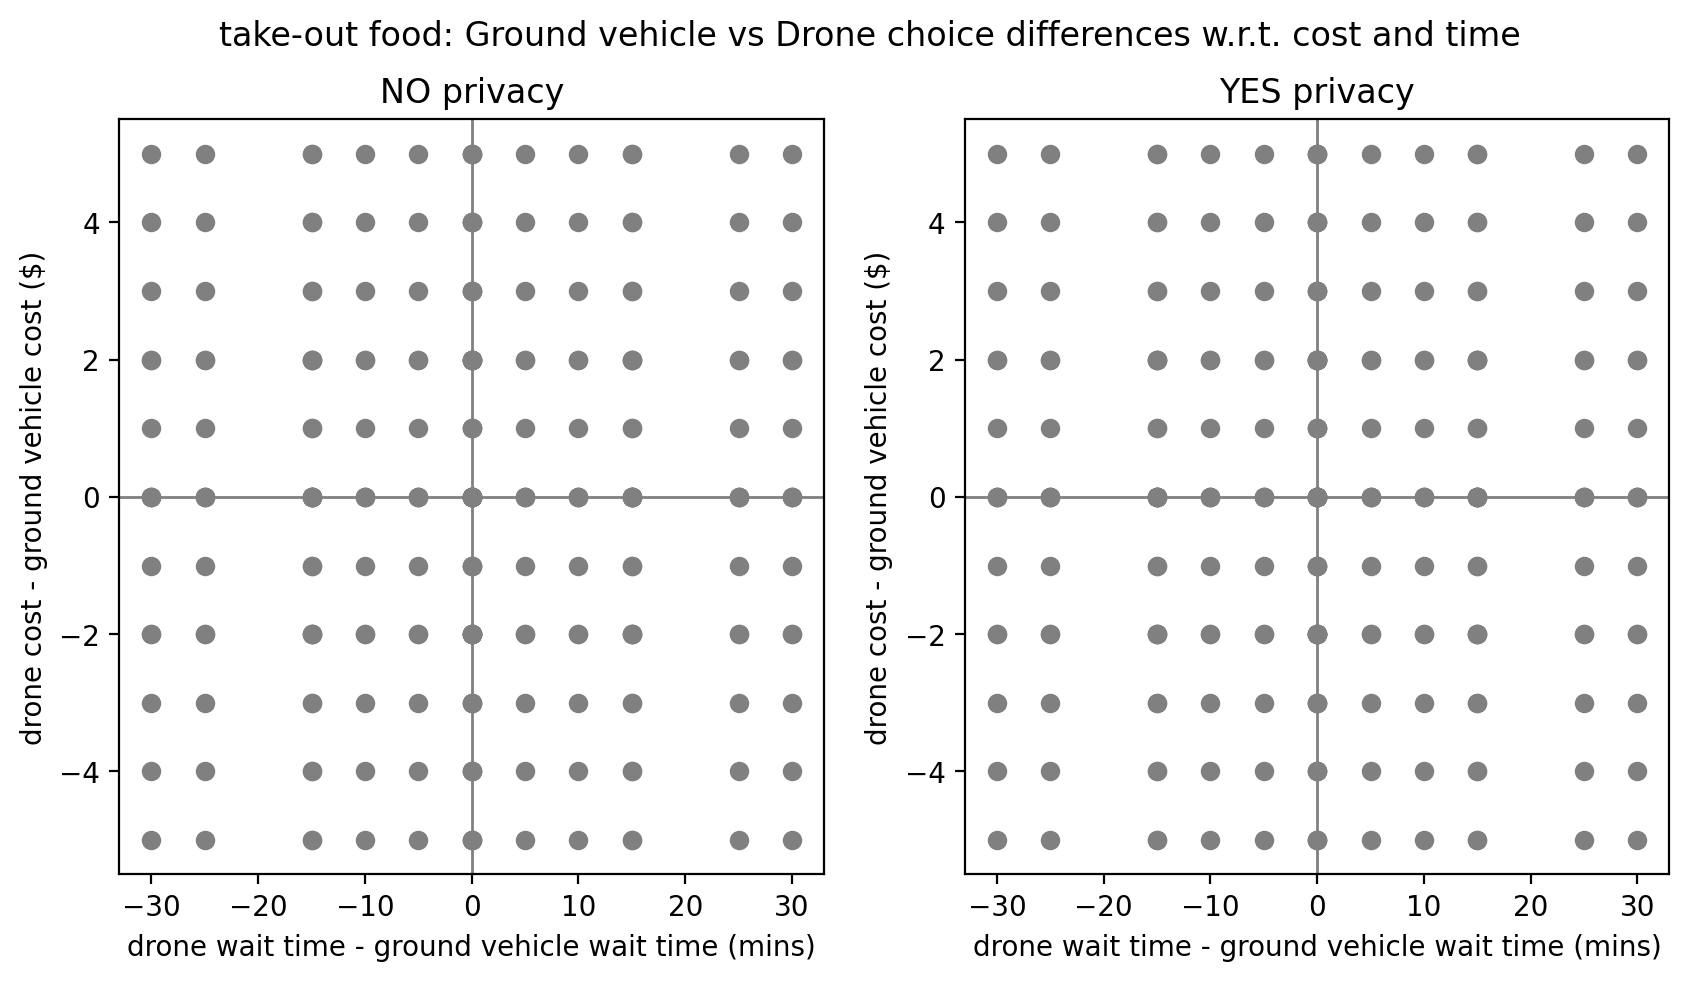

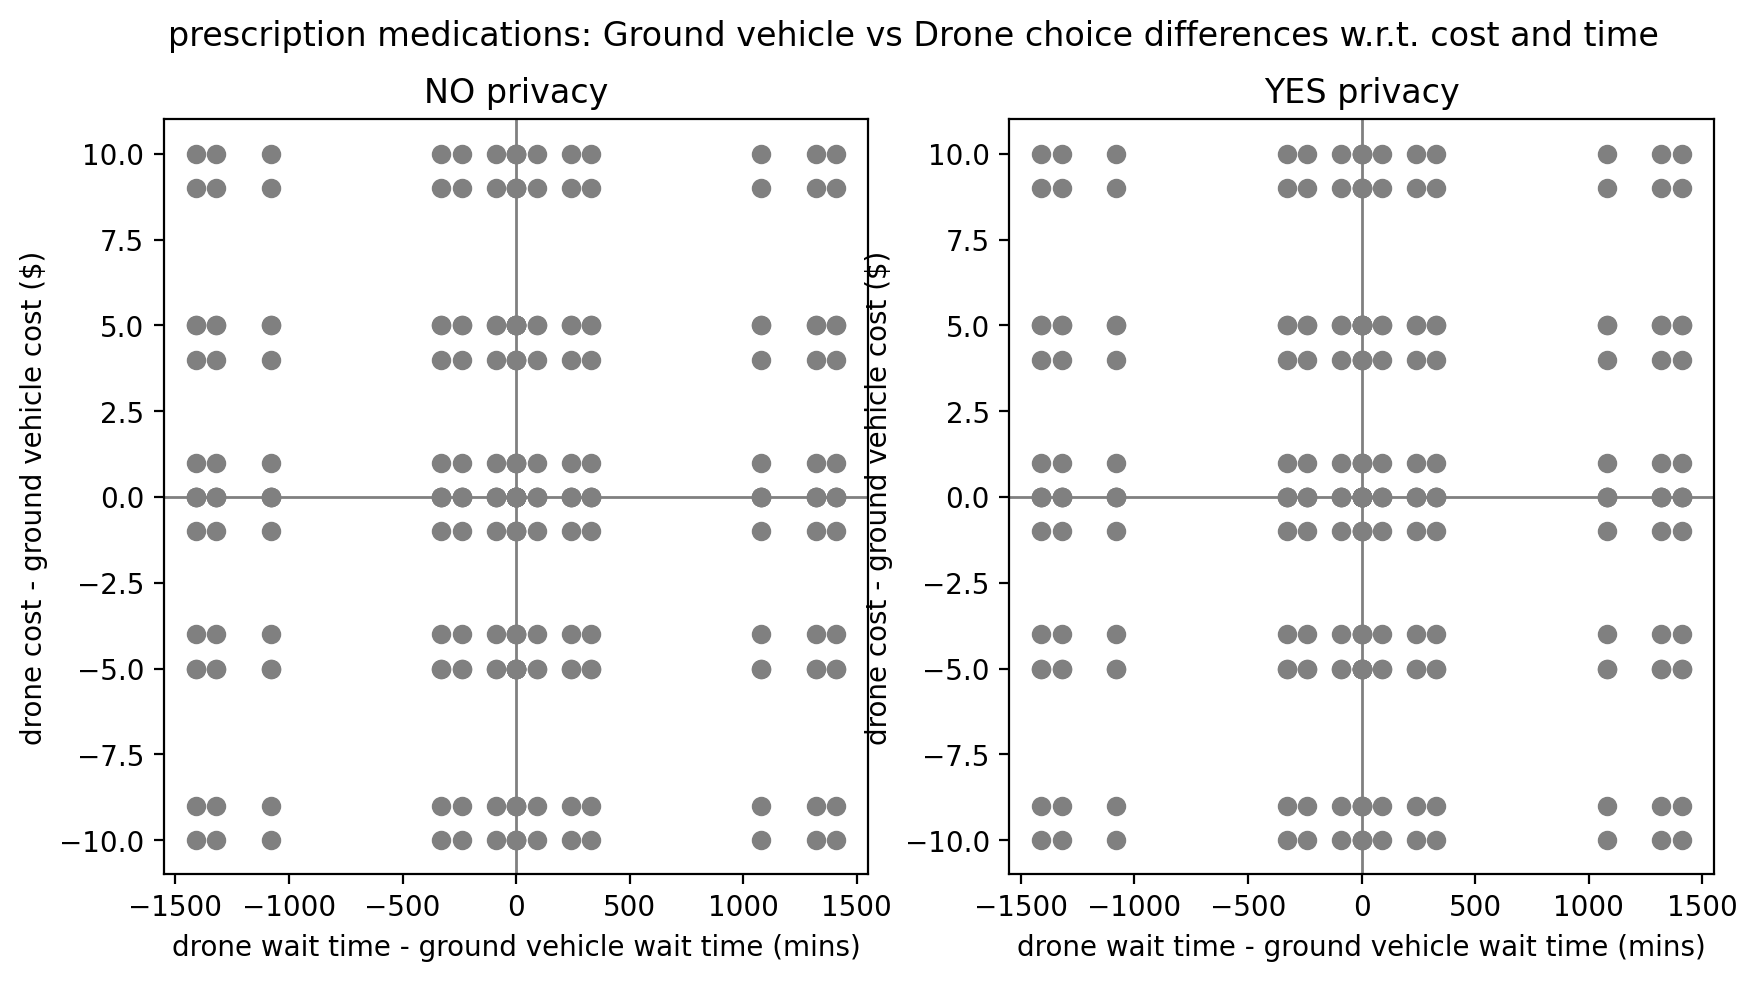

In [68]:
for v in [0,1]:
    vdf = df[df['v']==v]
    plot_points_tradeoff(vdf, VENDOR_TYPES[v])

### Exclude choices

Exclude a choice if one option is "dominant"

Simply exclude any choices where one alternative dominates the other w.r.t. both cost and time.



take-out food: 368 non-excluded choices


prescription medications: 368 non-excluded choices


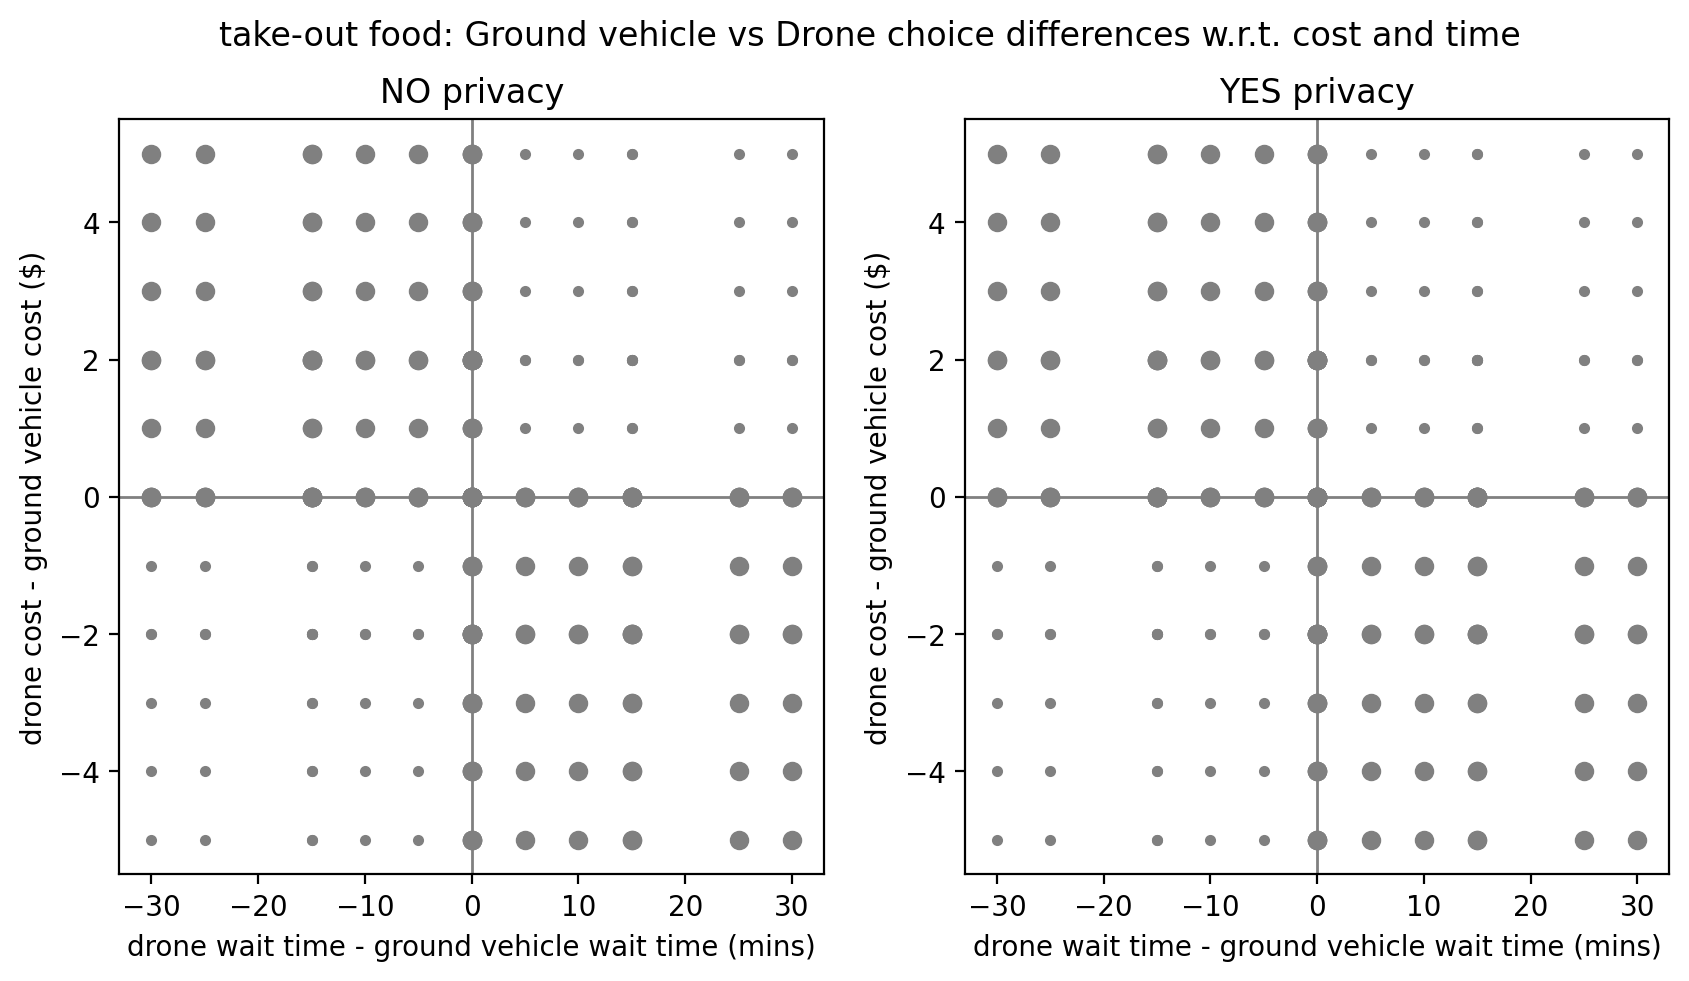

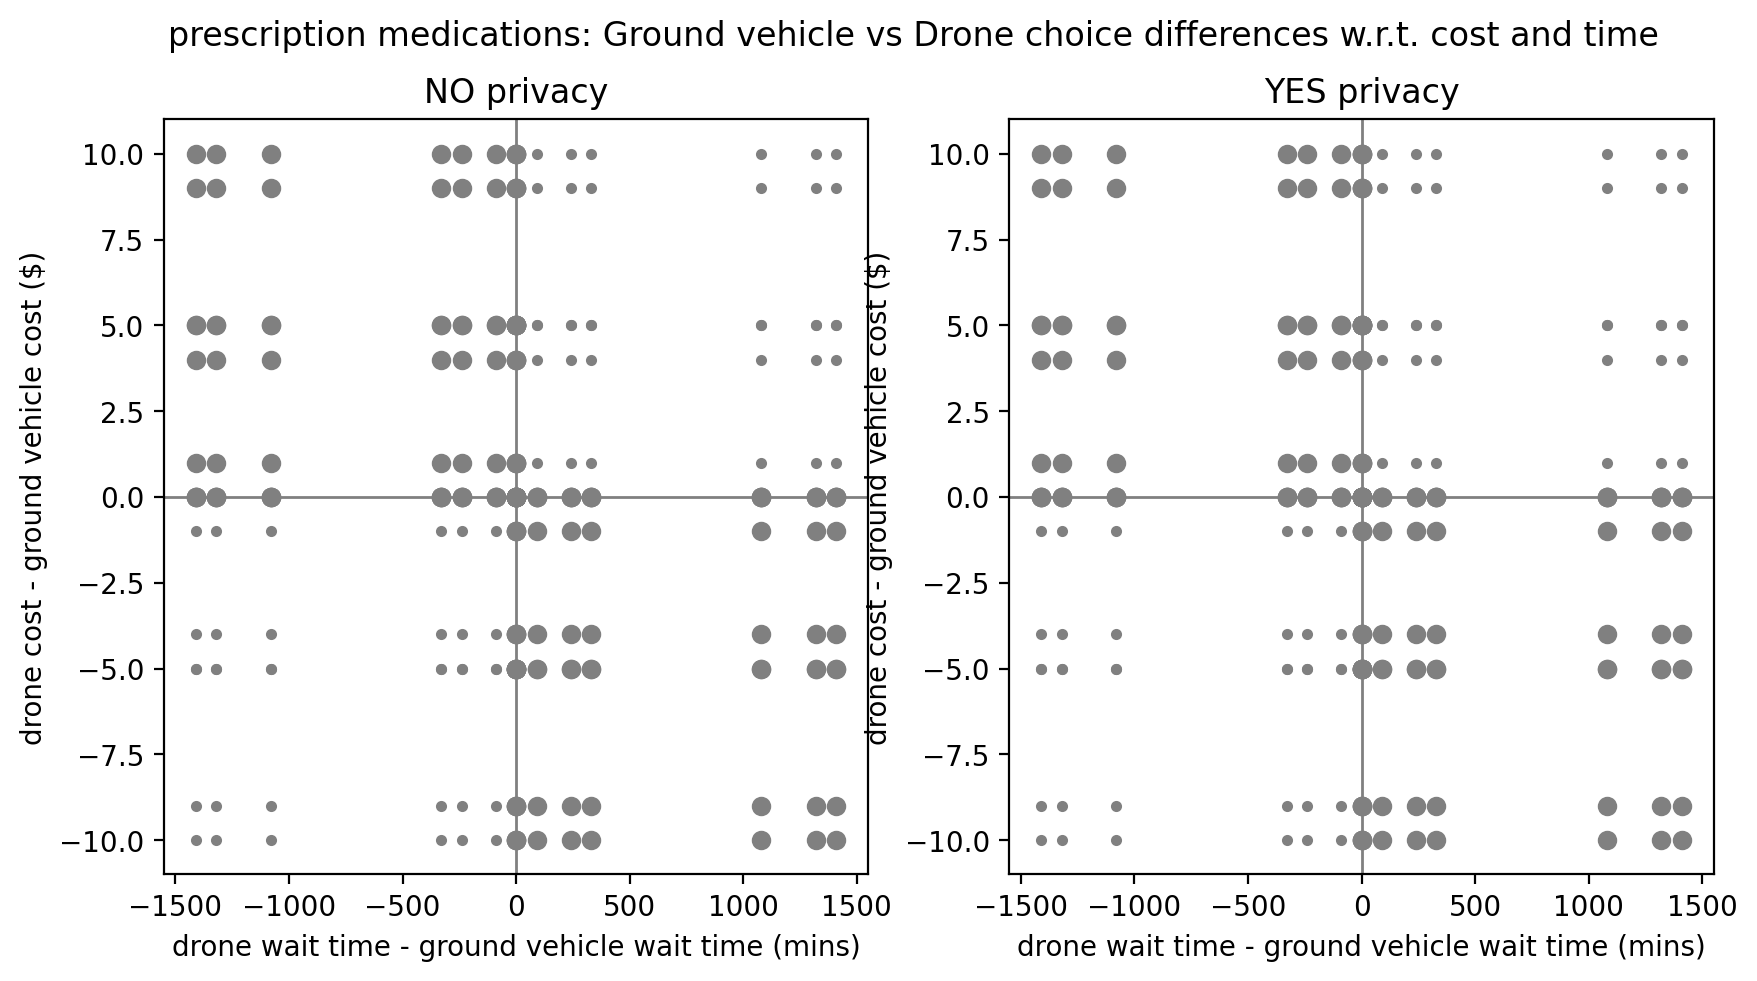

In [69]:
df['exclude'] = (
    ((df['dt'] - df['gt'] > 0) & (df['dc'] - df['gc'] > 0)) | \
    ((df['dt'] - df['gt'] < 0) & (df['dc'] - df['gc'] < 0))
)

for v in [0,1]:
    vdf = df[df['v']==v]
    v_type = VENDOR_TYPES[v]
    plot_points_tradeoff(vdf, v_type)
    print('%s: %s non-excluded choices' % (v_type, len(vdf[vdf['exclude']==False])))

Randomly sample a subset of non-excluded choices for which to generate questions.

Do this separately for vendor types.

In [70]:
QUESTIONS_SAMPLE_SIZE = 100

In [75]:
sampled_idx = np.append(
    np.random.choice(
        df[(df['exclude']==False) & (df['v']==0)].index,
        QUESTIONS_SAMPLE_SIZE, 
        replace=False
    ), 
    np.random.choice(
        df[(df['exclude']==False) & (df['v']==1)].index,
        QUESTIONS_SAMPLE_SIZE, 
        replace=False
    )
)
print('sampled index: %s' % sampled_idx)
print(len(df[df['sampled']==True]))
df['sampled'] = df.index.isin(sampled_idx)
df

sampled index: [ 127  179  212  258   91  378  139  266  368  381  221  304   99  411
  379    5  391  314  403  445  216  241  243  447  137  252  119  387
  140   34   98  124  144   48  307  407   42   50   25  208  121  332
  312   38  335  242  118    4   84  277   92  219  255  174  205  133
  373  105  380   59  326  250   97  428  418  142  257  440  294  336
  244  453  231  104   75  134  327  507   70  276   17  366  100  106
  196  281  120  233  253  470  295  410  303  305  236  398   57  311
  479  422  980  685  579  756  858  766  844  656  918  622  921  857
  761  896  758  551  988  616  853  771  653  628  967  720  906  675
  926  610 1014  683  721  585  751  617  755  911 1007  627  724  652
  769  785  823  608  998  880  957  787  908  870 1017  596  689  887
  763  790  626  529  946  939  764  632  750  640  793  650  927  624
  562  807  991  817  922  546  814  645  665  611 1018  850  854  536
 1006  802  696  885 1023  547  597  648 1022  839  965  824  

,v,v_type,gc,g_cost,gt,g_time,dc,d_cost,dt,d_time,dp,drone privacy,d_time - g_time,d_cost - g_cost,exclude,sampled
0,0,take-out food,0,0,0,15,0,0,0,15,0,0,0,0,False,False
1,0,take-out food,0,0,0,15,0,0,0,15,1,1,0,0,False,False
2,0,take-out food,0,0,0,15,0,0,1,20,0,0,5,0,False,False
3,0,take-out food,0,0,0,15,0,0,1,20,1,1,5,0,False,False
4,0,take-out food,0,0,0,15,0,0,2,30,0,0,15,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1,prescription medications,3,10,3,1440,3,10,1,120,1,1,-1320,0,False,False
1020,1,prescription medications,3,10,3,1440,3,10,2,360,0,0,-1080,0,False,False
1021,1,prescription medications,3,10,3,1440,3,10,2,360,1,1,-1080,0,False,False
1022,1,prescription medications,3,10,3,1440,3,10,3,1440,0,0,0,0,False,True




take-out food: 368 non-excluded choices
100 sampled choices


prescription medications: 368 non-excluded choices
100 sampled choices


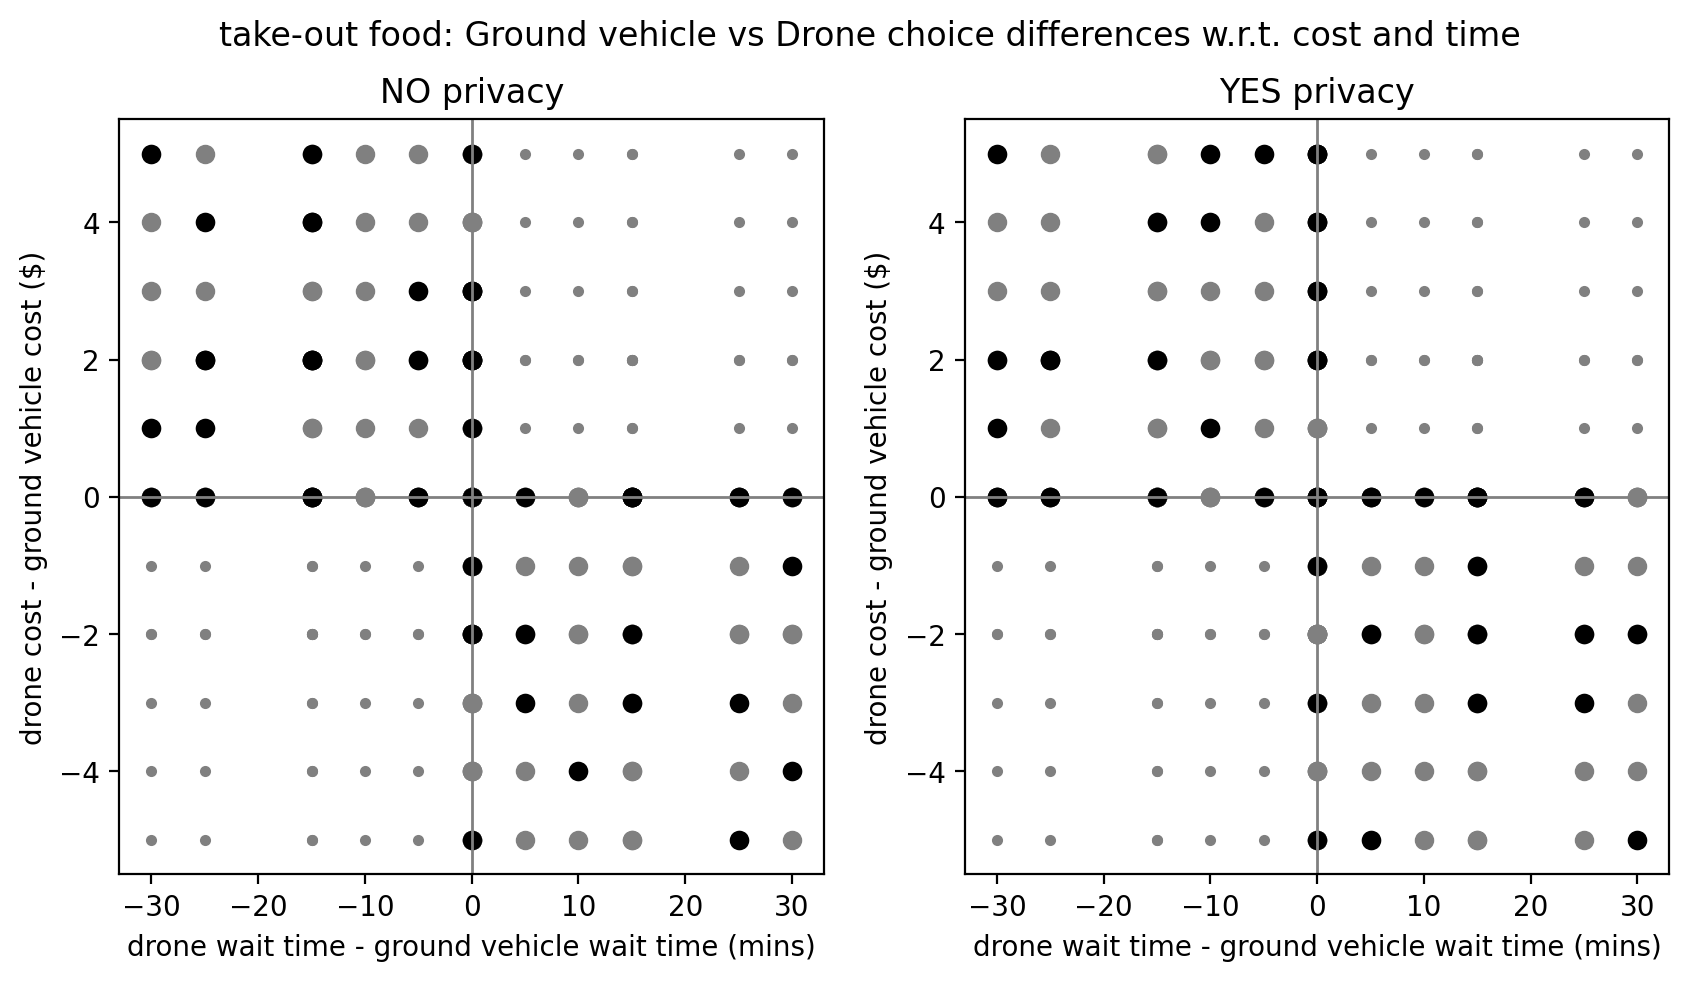

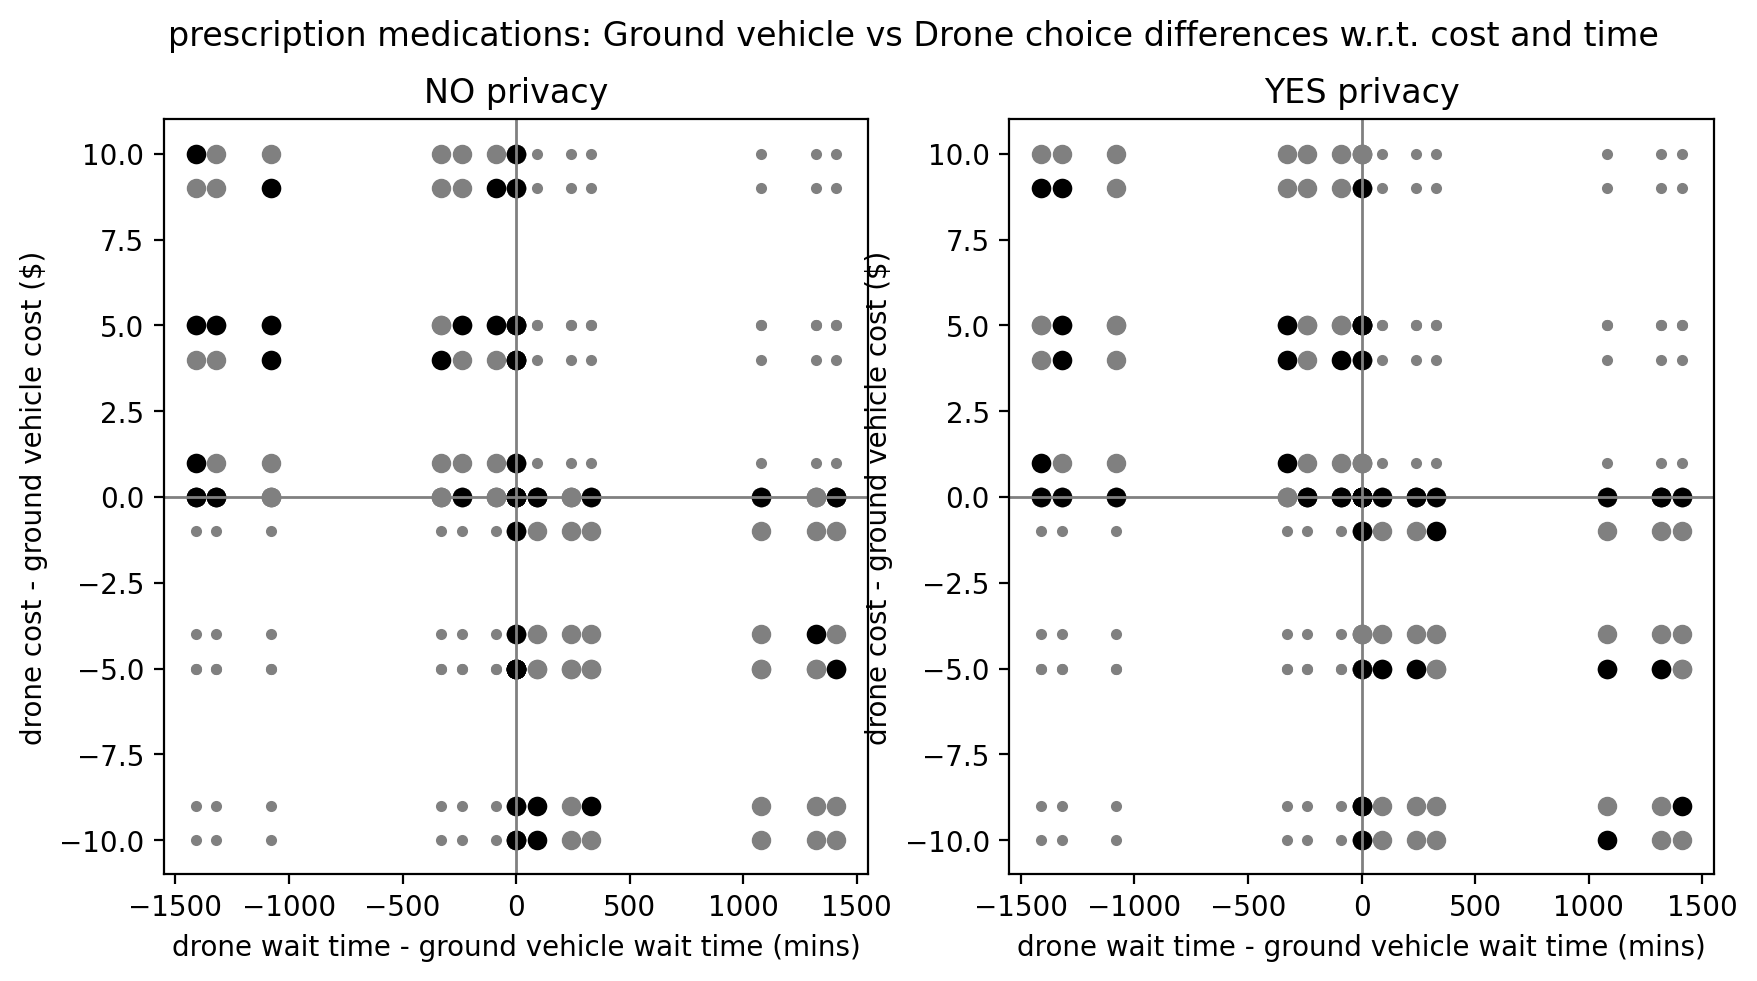

In [78]:
for v in [0,1]:
    vdf = df[df['v']==v]
    v_type = VENDOR_TYPES[v]
    plot_points_tradeoff(vdf, v_type)
    print('%s: %s non-excluded choices' % (v_type, len(vdf[vdf['exclude']==False])))
    print('%s sampled choices' % len(vdf[vdf['sampled']==True]))

Save choices to file

In [88]:
v_fpath = './choice-sets/surveyv1-choices-vendor%s-sampled-%s.csv'

In [89]:
save_columns = ['v','gc','gt','dt','dc','dp']

for v in [0,1]:
    vdf = df[df['v']==v]
    v_type = VENDOR_TYPES[v]
    v_filepath = v_fpath % (
        v, QUESTIONS_SAMPLE_SIZE
    )
    print('saving %s choices to file for vendor %s: %s to \n%s ...' % (
        QUESTIONS_SAMPLE_SIZE, v, v_type, v_filepath)
    )
    save_vdf = vdf[vdf['sampled']==True][save_columns]
    save_vdf.to_csv(v_filepath, index=False)
    print('...saved')



saving 100 choices to file for vendor 0: take-out food to 
./choice-sets/surveyv1-choices-vendor0-sampled-100.csv ...
...saved
saving 100 choices to file for vendor 1: prescription medications to 
./choice-sets/surveyv1-choices-vendor1-sampled-100.csv ...
...saved


In [91]:
test_df = pd.read_csv('./choice-sets/surveyv1-choices-vendor1-sampled-100.csv')
print(len(test_df))
test_df

100


,v,gc,gt,dt,dc,dp
0,1,0,0,0,2,1
1,1,0,0,0,3,0
2,1,0,1,0,0,1
3,1,0,1,1,0,0
4,1,0,1,1,0,1
...,...,...,...,...,...,...
95,1,3,3,3,2,0
96,1,3,3,0,3,1
97,1,3,3,1,3,0
98,1,3,3,3,3,0
